In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
GPU = torch.cuda.is_available()
print(GPU)
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

True


In [2]:
GPU = False
METAPRECISION = False

In [3]:
from __future__ import print_function
from __future__ import division
import os
import sys
import torch
import tqdm
import pdb
import numpy as np
import platform
import hashlib
import pytorch_transformer
import re
import argparse
import tensorflow as tf
from tensorflow.python import pywrap_tensorflow
import torch.nn.functional as F
#from torch.utils.tensorboard import SummaryWriter
from transformProtein import transformProtein
from ProteinDataset_uid import ProteinDataset
from torch.utils.data import Dataset, DataLoader
import pickle
import time
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
load_model_path = 'ckpt/' # just the folder itself

seq_length = 511
embedding_dim = 1280
num_layers = 36
vocab_loc = 'mapping_files/vocab.txt'

use_py3 = platform.python_version()[0] == '3'
vocab = open(vocab_loc).readlines() if not use_py3 else open(vocab_loc, encoding='utf-8').read().split('\n')[:-1]
vocab = list(map(lambda x: x.split(' ')[0], vocab))
vocab_size = len(vocab)
print('-----vocab size',vocab_size,'------')

class TiedEmbeddingSoftmax(torch.nn.Module):

    def __init__(self, vocab_size=vocab_size, embedding_size=embedding_dim, **kwargs):
        super(TiedEmbeddingSoftmax, self).__init__()
        self.w = torch.nn.Parameter(torch.normal(0., 1e-2, size=(vocab_size, embedding_size)))
        self.b = torch.nn.Parameter(torch.zeros(vocab_size))

    def forward(self, inputs, embed=True):
        with autocast(enabled=METAPRECISION):
            if embed:
                return torch.nn.functional.embedding(inputs, self.w)
            else:
                return torch.tensordot(inputs, self.w.t(), 1) + self.b

class CTRLmodel(torch.nn.Module):
    def __init__(self):
        super(CTRLmodel,self).__init__()
        self.tied_embedding_softmax = TiedEmbeddingSoftmax()
        self.encoder = pytorch_transformer.Encoder()

    def forward(self, inputs):
        with autocast(enabled=METAPRECISION):
            x = self.tied_embedding_softmax(inputs, embed=True)
            x = self.encoder(x)
            x = self.tied_embedding_softmax(x, embed=False)
        return x

    def loadCheckpoint(self, model_path, num_layers):
        if os.path.exists(model_path):
            print('Found PyTorch checkpoint at ', model_path)
            print('Loading instead of converting from TensorFlow')
            checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
            self.tied_embedding_softmax.load_state_dict({
                'w': checkpoint.pop('tied_embedding_softmax.w', None),
                'b': checkpoint.pop('tied_embedding_softmax.b', None)
            })
            self.encoder.load_state_dict({key.replace("encoder.", ""): value for key, value in checkpoint.items()})
        else:
            print('Could not find PyTorch checkpoint')
            sys.exit()

model = CTRLmodel()
print('model initialized')

curr_model_path = load_model_path+'pretrain_progen_full.pth'
reader = model.loadCheckpoint(model_path=curr_model_path, num_layers = num_layers)
print('previous checkpoint loaded')

'''
def compute_scaling_factor(model):
    # Initialize the scaling factor to a small value
    scale_factor = 1e-8
    # Iterate over all the model's parameters to find the maximum absolute value
    for param in model.parameters():
        if param.requires_grad:
            max_abs_value = torch.max(torch.abs(param.data))
            scale_factor = max(scale_factor, max_abs_value)
    return scale_factor

def scale_weights(model, scale_factor=128.0):
    # Scale all the model's parameters by the given factor
    for param in model.parameters():
        if param.requires_grad:
            param.data /= scale_factor
'''
            
if METAPRECISION:
    #scale_factor = compute_scaling_factor(model)
    #print("scaling factor: ", scale_factor)
    #scale_weights(model, scale_factor)
    model = model.to(torch.float16)
if GPU:
    model = model.cuda()
    print('previous checkpoint loaded in GPU')

optimizer = torch.optim.Adam(model.parameters()) #lr, betas

model.eval()

with open(os.path.join('mapping_files/','taxa_to_lineage.p'),'rb') as handle:
    taxa_to_lineage = pickle.load(handle)
with open('mapping_files/taxa_to_ctrl_idx.p','rb') as handle:
    taxa_to_ctrl_idx = pickle.load(handle)
with open('mapping_files/kw_to_ctrl_idx.p','rb') as handle:
    kw_to_ctrl_idx = pickle.load(handle)
with open('mapping_files/aa_to_ctrl_idx.p','rb') as handle:
    aa_to_ctrl_idx = pickle.load(handle)
with open('mapping_files/kw_to_name.p2','rb') as handle:
    kw_to_name = pickle.load(handle)
#with open('mapping_files/taxid_to_name.p2','rb') as handle:
#    taxid_to_name = pickle.load(handle)
# MANCANO:
# kw_to_lineage.p
# kw_to_parents.p
# taxa_to_parents.p
    
def flipdict(my_map):
    return {v: k for k, v in my_map.items()}
ctrl_idx_to_aa = flipdict(aa_to_ctrl_idx)
ctrl_idx_to_kw = flipdict(kw_to_ctrl_idx)
ctrl_idx_to_taxa = flipdict(taxa_to_ctrl_idx)

def predict_fn(inputs):
    with torch.no_grad():
        inputs = torch.tensor(inputs)
        if GPU:
            inputs = inputs.cuda()            
        output = model(inputs)
        output = output[:,:,-26:-1] # remove non-AA token logits
        return output

-----vocab size 129407 ------
MODEL SIZE: 
1280
model initialized
Found PyTorch checkpoint at  ckpt/pretrain_progen_full.pth
Loading instead of converting from TensorFlow
previous checkpoint loaded


In [8]:
import pickle
import os
# paths to the saved .p files
random_selection_file = os.path.join("data_random_selection_uniParc", "random_selection_10.p")
#data_file = os.path.join("data", "filtered_data_" + query + ".p")

# Reload random_selection from the .p file
random_selection = False
with open(random_selection_file, "rb") as file:
    random_selection = pickle.load(file)

# Reload filtered_data from the .p file
#filtered_data = False
#with open(data_file, "rb") as file:
#    filtered_data = pickle.load(file)

# Print or use the reloaded datasets as needed
print("Random Selection:")
for entry in random_selection:
    print(entry["sequence"]["value"])
    print(len(random_selection))
    print(entry)
    break

#print("---")

#print("Filtered Data:")
#for entry in filtered_data:
#    print(entry["sequence"])'''


Random Selection:
MLSAFWGHASAIAIASPVASIVGFQGDRTTIRRPTYGEMKFVEVVEKHRKMPTFPQSFPMNGGDGPHSYLHNSSYQKVAIDGAKERTREAILEKLDLELLNRNSDANILRIADFGCSIGPNTFDVVQNIIDTVKQKHLKKETHIGAPLEFQVSFNDQPNNDFNTLFRTQPLFSRREYLSVGVPGSFHGRVLPKNSLHIGHTSYTLHWLSTVPKHVCDKKSPALNKSYIQCNNLVDEVTKAYKIQFKKDIGGFLEARAEELVSGGLMILSGQCLPNGIPKALTCQGVVIDMIGDCLMDMAKLGITSKEKIEHFSLPTYIPHISEFKANIEQNENFTIETMEEISHPMDYMPLTNGFITSMFRAILNTIIEEHFGDGVVNELFDRLAKKLDKYPINFRRCKKYVNYFIVLKRK
10
{'entryType': 'UniProtKB unreviewed (TrEMBL)', 'primaryAccession': 'D7MK68', 'uniProtkbId': 'D7MK68_ARALL', 'entryAudit': {'firstPublicDate': '2010-08-10', 'lastAnnotationUpdateDate': '2023-02-22', 'lastSequenceUpdateDate': '2010-08-10', 'entryVersion': 44, 'sequenceVersion': 1}, 'annotationScore': 1.0, 'organism': {'scientificName': 'Arabidopsis lyrata subsp. lyrata', 'commonName': 'Lyre-leaved rock-cress', 'taxonId': 81972, 'evidences': [{'evidenceCode': 'ECO:0000313', 'source': 'Proteomes', 'id': 'UP000008694'}], 'lineage': ['Eukaryota', 'Viridiplantae', 'St

In [6]:
"""for entry in random_selection:
    taxid = int(entry['metadata']['source_organism']['taxId']) # taxonomy id from NCBI
    print(taxid)
    try:
        tax_lineage = taxa_to_lineage[taxid] # make lineage in ncbi ids
        print(tax_lineage)
        tax_lineage = [taxa_to_ctrl_idx[ite] for ite in tax_lineage] # now translated as ctrl code indices
        print(tax_lineage)
    except:
        print("Tax lineage error")
    # break"""

'for entry in random_selection:\n    taxid = int(entry[\'metadata\'][\'source_organism\'][\'taxId\']) # taxonomy id from NCBI\n    print(taxid)\n    try:\n        tax_lineage = taxa_to_lineage[taxid] # make lineage in ncbi ids\n        print(tax_lineage)\n        tax_lineage = [taxa_to_ctrl_idx[ite] for ite in tax_lineage] # now translated as ctrl code indices\n        print(tax_lineage)\n    except:\n        print("Tax lineage error")\n    # break'

<p>To evaluate the generated sequence using teacher forcing:

1. Generate the Sequence: The transformer model with teacher forcing generates the complete sequence. 
At each time step, we provide the true input sequence (+ 1 versus previous step), as input to the model.

2. Calculate Metrics: Accuracy, soft accuracy (based on BLOSUM matrix), perplexity. 

</p>

In [10]:

def teacher_forcing_generation(input_sequence, tax_lineage, penalty, topk):
    key_len = 0
    res = ""
    tokens_prob = []
    true_tokens_index_in_prob = []
    key_len = len(tax_lineage) # len(kw_lineage+tax_lineage)
    for i in range(1, len(input_sequence)):
        iteration_input_prefix = input_sequence[:i]
        seed_seq = [aa_to_ctrl_idx[ii] for ii in iteration_input_prefix]
        generate_num = key_len + len(seed_seq) + 1 # how many tokens to generate, here only one
        seq_length = min(generate_num, 511)
        text = tax_lineage + seed_seq # tax_lineage + kw_lineage + seed_seq
        padded_text = text + [0] * (generate_num - len(text))
        tokens_generated = np.tile(padded_text, (1,1))
        for token in range(len(text)-1, generate_num-1):
            prompt_logits = predict_fn(tokens_generated[:, :seq_length]).squeeze()
            _token = token if token < seq_length else -1
            prompt_logits = prompt_logits.cpu().detach().numpy()
            #print(tokens_generated[:, :seq_length])
            #print(prompt_logits)
            if penalty>0:
                penalized_so_far = set()
                # variable token_flag for first amminoacids (to count them if they are less that 4)
                if token >= key_len + 3:
                    token_flag = 3  
                elif token - key_len - 3 <= 0:
                    token_flag = 0
                else:
                    token_flag = token
                for _ in range(token-token_flag,token+1):
                    generated_token = tokens_generated[0][_] - (vocab_size-26) # added
                    if generated_token in penalized_so_far:
                        continue
                    penalized_so_far.add(generated_token)
                    prompt_logits[_token][generated_token] /= penalty  
            # compute probabilities from logits
            prompt_probs = np.exp(prompt_logits[_token])
            prompt_probs = prompt_probs / sum(prompt_probs)
            pruned_list = np.argsort(prompt_probs)[::-1]
            codice_aa_della_true_sequence = seed_seq[_token - key_len]
            idx_true = codice_aa_della_true_sequence - vocab_size + 26
            true_tokens_index_in_prob.append([idx_true])
            tokens_prob.append([prompt_probs.tolist()])

            if topk==1:
                idx = pruned_list[0]
            else:
                pruned_list = pruned_list[:topk]
                chosen_idx = torch.distributions.categorical.Categorical(logits=torch.tensor(np.expand_dims(prompt_logits[_token][pruned_list],0))).sample().numpy()[0]
                idx = pruned_list[chosen_idx]
            # assign the token for generation
            idx += (vocab_size-26) # added to convert 0 AA to original ctrl idx
            tokens_generated[0][token+1] = idx
        tokens_generated_so_far = tokens_generated[0].squeeze()[:token+2]
        tokens_generated_so_far = tokens_generated_so_far[(tokens_generated_so_far>=(vocab_size-26)) & (tokens_generated_so_far<(vocab_size-1))]
        tokens_generated_so_far = ''.join([ctrl_idx_to_aa[c] for c in tokens_generated_so_far])
        query = tokens_generated_so_far[len(seed_seq):]
        res += query
    return res, tokens_prob, true_tokens_index_in_prob


In [11]:

import pickle
# print("on data: ", query)
penalty = 1.2
topk = 3
predicted = []
true_tokens_index_in_probs_all = []
tokens_probs_all = []
true_value = []
for entry in random_selection:
    input_seq = entry['sequence']['value']
    taxid = None # taxonomy id from NCBI DA IMPLEMENTARE
    """try:
        tax_lineage = taxa_to_lineage[taxid] # make lineage in ncbi ids
        tax_lineage = [taxa_to_ctrl_idx[ite] for ite in tax_lineage] # now translated as ctrl code indices
    except:
        print("ALERT: error in taxonmy conversions for entry: ", taxid)
        try:
            tax_lineage = taxa_to_ctrl_idx[taxid]
        except:
            print("ALERT: taxonomy id error for entry: ", taxid)
            try:
                tax_lineage = [taxa_to_ctrl_idx[ite] for ite in tax_lineage[:-1]]
                print("ALERT: taxonomy id error for entry: ", taxid, ", but lineage found.")
            except:
                print("ALERT: taxonomy id error for entry: ", taxid, ", and error of lineage.")
                tax_lineage = []"""
    # FOR TESTIG the code:
    # input_seq = input_seq[0:4]
    
    # if no tax keys:
    tax_lineage = []
    
    try:
        res, tokens_prob, true_tokens_index_in_prob = teacher_forcing_generation(input_seq, tax_lineage,
                                                                                 penalty, topk)
    except:
        print("ALERT: skipped for error the entry: ", entry)
        continue
    # print("Input: ", input_seq)
    # print("Res: ", res)
    true_value.append(input_seq)
    true_tokens_index_in_probs_all.append(true_tokens_index_in_prob)
    tokens_probs_all.append(tokens_prob)
    predicted.append(input_seq[0] + res)

    # FOR TESTIG:
    #break
    
    

In [12]:
# Create a directory named "ID_test_data" in the current working directory if it doesn't exist
data_dir = "data_random_selection_uniParc/10_sequences_p_1.2_topk_3"
os.makedirs(data_dir, exist_ok=True)

# TODO, salvare tokens_prob e true_tokens_index_in_prob
tokens_probs_data_file = os.path.join(data_dir, "tokens_probs_data.p")
with open(tokens_probs_data_file, "wb") as file:
    pickle.dump(tokens_probs_all, file)
    
true_tokens_index_data_file = os.path.join(data_dir, "true_tokens_index_data.p")
with open(true_tokens_index_data_file, "wb") as file:
    pickle.dump(true_tokens_index_in_probs_all, file)

# Save ID_test_data as a .p file
predicted_data_file = os.path.join(data_dir, "predicted_data.p")
with open(predicted_data_file, "wb") as file:
    pickle.dump(predicted, file)
    
# Save ID_test_data as a .p file
true_data_file = os.path.join(data_dir, "true_data.p")
with open(true_data_file, "wb") as file:
    pickle.dump(true_value, file)
torch.cuda.empty_cache()

In [13]:
print(input_seq[0] + res)

MSKI


In [14]:
print(input_seq)

MITL


In [9]:
len(input_seq)

889

<h3>Evaluations</h3>

In [13]:
# Da implementare compute_perplexity
from nltk import ngrams
from sklearn.metrics import accuracy_score
import math
import blosum as bl
import torch
from torcheval.metrics.text import Perplexity
import decimal
import statistics
# desired precision for printing float values
decimal.getcontext().prec = 18
#  BLOSUM62 is the matrix built using sequences with less than 62% similarity 
# (sequences with ≥ 62% identity were clustered)

def compute_hard_accuracy(true_string, predicted_string):
    # percentage of predictions that exactly match the ground truth labels
    total_characters = len(true_string)
    assert total_characters == len(predicted_string)
    # Convert strings to lists of characters
    true_list = list(true_string)
    predicted_list = list(predicted_string)
    # Compute hard accuracy using accuracy_score function
    hard_accuracy = accuracy_score(true_list, predicted_list)
    return hard_accuracy

def compute_all_hard_accuracies(true_sequences, predicted_sequences):
    num_seq = len(true_sequences)
    assert num_seq == len(predicted_sequences)
    accuracy_all = []
    accuracy_dict = {0:[], 50:[], 100:[], 150:[], 200:[], 250:[], 300:[], 350:[], 400:[], 
                     450:[], 500:[], 550:[], 600:[], 650:[], 700:[], 750:[], 800:[], 850:[], 900:[]}
    for i in range(num_seq):
        sequence = true_sequences[i]
        predicted_sequence = predicted_sequences[i]
        tmp_acc = compute_hard_accuracy(sequence, predicted_sequence)
        accuracy_all.append(tmp_acc)
        for j in range(0, len(sequence)-49, 50):
            tmp_acc = compute_hard_accuracy(sequence[j:j+50], predicted_sequence[j:j+50])
            accuracy_dict[j].append(float(tmp_acc))       
    result = sum(accuracy_all) / num_seq
    for key in accuracy_dict:
        if len(accuracy_dict[key]) <= 0:
            break
        accuracy_dict[key] = sum(accuracy_dict[key])/len(accuracy_dict[key])
    st_deviation = statistics.stdev(accuracy_all)
    result = (result, st_deviation)
    return result, accuracy_dict

def compute_soft_accuracies(true_sequences, predicted_sequences, threshold = 0):
    # soft accuracy takes into account partial matches or similarities 
    # between the predictions and the ground truth labels
    bl_matrix = bl.BLOSUM(62)
    num_seq = len(true_sequences)
    assert num_seq == len(predicted_sequences)
    accuracy_all = []
    accuracy_dict = {0:[], 50:[], 100:[], 150:[], 200:[], 250:[], 300:[], 350:[], 
                     400:[], 450:[], 500:[], 550:[], 600:[], 650:[], 700:[], 750:[], 800:[], 850:[], 900:[]}
    for i in range(num_seq):
        sequence = true_sequences[i]
        predicted_sequence = predicted_sequences[i]
        tmp_acc = calculate_soft_accuracy(sequence, predicted_sequence, bl_matrix, threshold)
        accuracy_all.append(tmp_acc)
        for j in range(0, len(sequence)-49, 50):
            tmp_acc = calculate_soft_accuracy(sequence[j:j+50], predicted_sequence[j:j+50], bl_matrix, threshold)
            accuracy_dict[j].append(tmp_acc) 
    result = sum(accuracy_all) / num_seq
    for key in accuracy_dict:
        if len(accuracy_dict[key]) <= 0:
            break
        accuracy_dict[key] = sum(accuracy_dict[key])/len(accuracy_dict[key])
    st_deviation = statistics.stdev(accuracy_all)
    result = (result, st_deviation)
    return result, accuracy_dict

def calculate_soft_accuracy(true_sequence, predicted_sequence, bl_matrix, threshold = 0):
    total_characters = len(true_sequence)
    assert total_characters == len(predicted_sequence)
    partial_matches = 0
    for true_aa, predicted_aa in zip(true_sequence, predicted_sequence):
        similarity_score = bl_matrix[true_aa][predicted_aa]
        if similarity_score >= threshold:
            partial_matches += 1
    soft_accuracy = partial_matches / total_characters
    return soft_accuracy

def compute_perplexity(probs, indexes):    
    metric = Perplexity()
    input = probs
    target = indexes
    metric.update(input, target)
    perplexity = metric.compute()
    return perplexity

def compute_perplexities(probs_all, indexes_all):
    num_seq = len(indexes_all)
    try:
        indexes_all[0][0][0]
    except TypeError: 
        indexes = torch.tensor(indexes_all)
        probs = torch.tensor(probs_all)
        tmp_perplexity = compute_perplexity(probs, indexes)
        return tmp_perplexity
    assert num_seq == len(probs_all)
    perplexity_all = []
    perplexity_dict = {0:[], 50:[], 100:[], 150:[], 200:[], 250:[], 300:[], 350:[], 400:[], 
                       450:[], 500:[], 550:[], 600:[], 650:[], 700:[], 750:[], 800:[], 850:[], 900:[]}
    for i in range(num_seq):
        indexes = torch.tensor(indexes_all[i])
        probs = torch.tensor(probs_all[i])
        tmp_perplexity = compute_perplexity(probs, indexes)
        perplexity_all.append(tmp_perplexity)
        for j in range(0, len(indexes)-49, 50):
            tmp_acc = compute_perplexity(probs[j:j+50], indexes[j:j+50])
            perplexity_dict[j].append(tmp_acc)  
    result = sum(perplexity_all) / num_seq
    for key in perplexity_dict:
        if len(perplexity_dict[key]) <= 0:
            break
        perplexity_dict[key] = float(sum(perplexity_dict[key])/len(perplexity_dict[key]))
    st_deviation = np.std(perplexity_all) # OR np.std
    result = (float(result), float(st_deviation))
    return result, perplexity_dict

/home/mnicolini/miniconda3/envs/venvProGen/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [14]:
import pickle
# paths to the saved .p files
predicted_data_file = os.path.join(data_dir, "predicted_data.p")
true_data_file = os.path.join(data_dir, "true_data.p")
indexes_all_data_file = os.path.join(data_dir, "true_tokens_index_data.p")
probs_all_data_file = os.path.join(data_dir, "tokens_probs_data.p")

# Reload predicted_data from the .p file
predicted_data = False
with open(predicted_data_file, "rb") as file:
    predicted_data = pickle.load(file)

# Reload true_data from the .p file
true_data = False
with open(true_data_file, "rb") as file:
    true_data = pickle.load(file)
    
# Reload probs_all_data from the .p file
probs_all_data = False
with open(probs_all_data_file, "rb") as file:
    probs_all_data = pickle.load(file)
    
# Reload indexes_all_data from the .p file
indexes_all_data = False
with open(indexes_all_data_file, "rb") as file:
    indexes_all_data = pickle.load(file)

# Compute hard accuracy
accuracy, accuracy_dict = compute_all_hard_accuracies(true_data, predicted_data)

# Compute perplexity
perplexity, perplexity_dict = compute_perplexities(probs_all_data, indexes_all_data)

# Compute soft accuracy
soft_accuracy, soft_accuracy_dict = compute_soft_accuracies(true_data, predicted_data)

print("Accuracy (acc/std):", accuracy, "\nSoft accuracy (acc/std):", 
      soft_accuracy, "\nPerplexity (perpl/std): ", perplexity)
print("\n\nAccuracy dict:", accuracy_dict, "\n\nSoft accuracy dict:", 
      soft_accuracy_dict, "\n\nPerplexity dict: ", perplexity_dict)
# print(true_data)
# print(predicted_data)

Accuracy (acc/std): (0.22410384233276295, 0.20601029077228103) 
Soft accuracy (acc/std): (0.510904481607557, 0.1592862838202765) 
Perplexity (perpl/std):  (25.79782188277282, 0.2772609643671867)
Accuracy dict: {0: 0.18000000000000002, 50: 0.2555555555555556, 100: 0.29500000000000004, 150: 0.2333333333333333, 200: 0.20800000000000002, 250: 0.215, 300: 0.32, 350: 0.28, 400: 0.49, 450: 0.49, 500: 0.2, 550: 0.12, 600: 0.18, 650: 0.1, 700: 0.08, 750: 0.06, 800: [], 850: [], 900: []} 
Soft accuracy dict: {0: 0.43599999999999994, 50: 0.5288888888888889, 100: 0.575, 150: 0.5399999999999999, 200: 0.504, 250: 0.54, 300: 0.64, 350: 0.6533333333333333, 400: 0.77, 450: 0.71, 500: 0.5, 550: 0.38, 600: 0.58, 650: 0.44, 700: 0.42, 750: 0.36, 800: [], 850: [], 900: []} 
Perplexity dict:  {0: 25.769189491882297, 50: 25.70301921552545, 100: 25.796845931093532, 150: 25.858135067289837, 200: 25.897314484498857, 250: 25.89134832387849, 300: 25.941313105567566, 350: 25.941564198601558, 400: 25.79719548909825

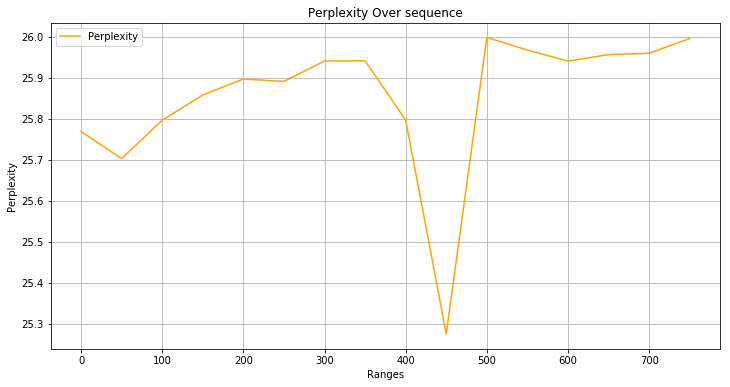

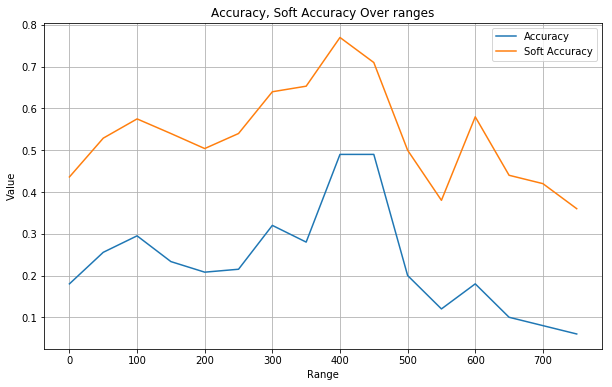

In [15]:
accur_dict = accuracy_dict
soft_accur_dict = soft_accuracy_dict
perplex_dict = perplexity_dict
import matplotlib.pyplot as plt


# Filter out the empty values for perplexity
x_values_perplexity = [x for x in accur_dict.keys() if perplex_dict[x]]
perplexity_values = [perplex_dict[x] for x in x_values_perplexity]

# Plot accuracy and soft accuracy on one graph
plt.figure(figsize=(12, 6))

plt.plot(x_values_perplexity, perplexity_values, label='Perplexity', color='orange')

# Set labels and title
plt.xlabel('Ranges')
plt.ylabel('Perplexity')
plt.title('Perplexity Over sequence')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


# Create lists for x-axis and corresponding values for each dictionary
# Filter out the empty values
x_values = [x for x in accur_dict.keys() if accur_dict[x] and soft_accur_dict[x] and perplex_dict[x]]
accuracy_values = [accur_dict[x] for x in x_values]
soft_accuracy_values = [soft_accur_dict[x] for x in x_values]


# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(x_values, accuracy_values, label='Accuracy')
plt.plot(x_values, soft_accuracy_values, label='Soft Accuracy')

# Set labels and title
plt.xlabel('Range')
plt.ylabel('Value')
plt.title('Accuracy, Soft Accuracy Over ranges')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
    
    

<h3>Code to make understand and debug</h3>

In [13]:
# DEVELOPMENT
# Example usage of perplexity computation
probs_all = [[[[0.3, 0.7]], [[0.6, 0.4]]], [[[0.2, 0.8]], [[0.5, 0.5]]]]
indexes_all = [[[0], [1]], [[1], [0]]]

perplexity = compute_perplexities(probs_all, indexes_all)
print("perplexity:", perplexity)


perplexity: (2.0563691990737216, {0: [], 50: [], 100: [], 150: [], 200: [], 250: [], 300: [], 350: [], 400: [], 450: []})


In [14]:
# DEVELOPMENT
# Example usage of hard and soft accuracy computation
true_sequences =      ['LS', 'LLPL', 'OOOOOOO'] # List of true sequences MITIMMNFHN
predicted_sequences = ['MS', 'OOOO', 'ASSSSSS']  # List of predicted sequences

# Compute hard accuracy
accuracy = compute_all_hard_accuracies(true_sequences, predicted_sequences)

# Compute soft accuracy
soft_accuracy = compute_soft_accuracies(true_sequences, predicted_sequences)

print("Accuracy:", accuracy, "\nSoft accuracy:", soft_accuracy)

Accuracy: (0.16666666666666666, {0: [], 50: [], 100: [], 150: [], 200: [], 250: [], 300: [], 350: [], 400: [], 450: []}) 
Soft accuracy: (0.3333333333333333, {0: [], 50: [], 100: [], 150: [], 200: [], 250: [], 300: [], 350: [], 400: [], 450: []})


<h3>Old Progen Generation Code:</h3>

In [15]:
print(kw_to_name[9])
taxid = 9606 # homo sapiens taxonomy id from NCBI: https://www.ncbi.nlm.nih.gov/taxonomy
tax_lineage = taxa_to_lineage[taxid] # make lineage in ncbi ids
print(tax_lineage)
tax_lineage = [taxa_to_ctrl_idx[ite] for ite in tax_lineage] # now translated as ctrl code indices
print(tax_lineage)

kw_lineage = [677,9] # UniprotKB keywords from https://www.uniprot.org/docs/keywlist
print(kw_lineage)
kw_lineage = [kw_to_ctrl_idx[ite] for ite in kw_lineage] # now translated to ctrl code indices
print(kw_lineage)


example_seq = 'YMIQEEEWDRDLLLDPAWEKQQRKTFTAWCNSHLRKAGTQIENIEEDFRNGLKLMLLLEVISGERLPKPDRGKMRFHKIANVNKALDYIASKGVKLVSIGAEEIVDGNVKMTLGMIWTIILRFAIQDISVEETSAKEGLLLWCQRKTAPYRNVNIQNFHTSWKDGLGLCALIHRHRPDLIDYSKLNKDDPIGNINLAMEIAEKHLDIPKMLDAEDIVNTPKPDERAIMTYVSCFYHAFAGAEQAETAANRICKVLAVNQENERLMEEYERLASELLEWIRRTIPWLENRTPAATMQAMQKKLEDFRDYRRKHKPPKVQEKCQLEINFNTLQTKLRISNRPAFMPSEGKMVSDIAGAWQRLEQAEKGYEEWLLNEIRRLERLEHLAEKFRQKASTHETWAYGKEQILLQKDYESASLTEVRALLRKHEAFESDLAAHQDRVEQIAAIAQELNELDYHDAVNVNDRCQKICDQWDRLGTLTQKRREALERMEKLLETIDQLHLEFAKRAAPFNNWMEGAMEDLQDMFIVHSIEEIQSLITAHEQFKATLPEADGERQSIMAIQNEVEKVIQSYNIRISSSNPYSTVTMDELRTKWDKVKQLVPIRDQSLQEELARQHANERLRRQFAAQANAIGPWIQNKMEEIARSSIQITGALEDQMNQLKQYEHNIINYKNNIDKLEGDHQLIQEALVFDNKHTNYTMEHIRVGWELLLTTIARTINEVETQILTRDAKGITQEQMNEFRASFNHFDRRKNGLMDHEDFRACLISMGYDLGEAEFARIMTLVDPNGQGTVTFQSFIDFMTRETADTDTAEQVIASFRILASDKPYILAEELRRELPPDQAQYCIKRMPAYSGPGSVPGALDYAAFSSALYGESDL'
prefix = example_seq[:3]
# prefix = ""
print("Prefix: ", prefix)
ref = example_seq[0:20]

print("Ref: ", ref)
penalty = 1.2
topk = 3

seed_seq = [aa_to_ctrl_idx[ii] for ii in prefix]
print("seed sequence: ", seed_seq)
# generate_num = len(kw_lineage+tax_lineage)+len(prefix+ref)
key_len = len(kw_lineage+tax_lineage)
generate_num = key_len +len(prefix+ref)
seq_length = min(generate_num, 511)

text = tax_lineage + kw_lineage + seed_seq
padded_text = text + [0] * (generate_num - len(text))
print(padded_text)
tokens_generated = np.tile(padded_text, (1,1))

#i = 1
for token in range(len(text)-1, generate_num-1):
    #print("counter: ", i)
    #i += 1
    print(tokens_generated[:, :seq_length].shape)
    prompt_logits = predict_fn(tokens_generated[:, :seq_length]).squeeze()
    _token = token if token < seq_length else -1
    if GPU:
        prompt_logits = prompt_logits.cpu().detach().numpy()
    else:
        prompt_logits = prompt_logits.gpu().detach().numpy()

    if penalty>0:
        penalized_so_far = set()
        # variable token_flag for first amminoacids (to count them if they are less that 4)
        if token >= key_len + 3:
            token_flag = 3  
        elif token - key_len - 3 <= 0:
            token_flag = 0
        else:
            token_flag = token
        #print(key_len)
        #print(token)
        #print(token_flag)
        for _ in range(token-token_flag,token+1):
            generated_token = tokens_generated[0][_] - (vocab_size-26) # added
            if generated_token in penalized_so_far:
                continue
            penalized_so_far.add(generated_token)
            prompt_logits[_token][generated_token] /= penalty

    # compute probabilities from logits
    prompt_probs = np.exp(prompt_logits[_token])
    prompt_probs = prompt_probs / sum(prompt_probs)
    pruned_list = np.argsort(prompt_probs)[::-1]

    if topk==1:
        idx = pruned_list[0]
    else:
        pruned_list = pruned_list[:topk]
        chosen_idx = torch.distributions.categorical.Categorical(logits=torch.tensor(np.expand_dims(prompt_logits[_token][pruned_list],0))).sample().numpy()[0]
        idx = pruned_list[chosen_idx]

    # assign the token for generation
    idx += (vocab_size-26) # added to convert 0 AA to original ctrl idx
    tokens_generated[0][token+1] = idx


tokens_generated_so_far = tokens_generated[0].squeeze()[:token+2]
tokens_generated_so_far = tokens_generated_so_far[(tokens_generated_so_far>=(vocab_size-26)) & (tokens_generated_so_far<(vocab_size-1))]
tokens_generated_so_far = ''.join([ctrl_idx_to_aa[c] for c in tokens_generated_so_far])

query = tokens_generated_so_far[len(seed_seq):]

print(prefix)
print(query)

Actin-binding
[33208, 7711, 40674, 9443, 9604, 9605, 9606]
[11177, 5756, 14034, 6957, 7068, 7069, 7070]
[677, 9]
[46, 258]
Prefix:  YMI
Ref:  YMIQEEEWDRDLLLDPAWEK
seed sequence:  [129404, 129392, 129389]
[11177, 5756, 14034, 6957, 7068, 7069, 7070, 46, 258, 129404, 129392, 129389, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(1, 32)


AttributeError: 'Tensor' object has no attribute 'gpu'